# Time Series Forecasting with LSTM in PyTorch

## Abstract
This notebook provides a comprehensive guide to time series forecasting using Long Short-Term Memory (LSTM) networks implemented in PyTorch. The tutorial covers the entire workflow, from loading and preprocessing a financial dataset to defining, training, and evaluating an LSTM model. By the end of this notebook, users will have a solid understanding of how to apply LSTM networks for predicting stock or cryptocurrency prices, along with visualizing the model's performance against actual values.

## Content
1. **Introduction**: Overview of the notebook and its objectives.
2. **Load and Preprocess Data**: Steps to load, normalize, and prepare the time series data for training.
3. **Define the LSTM Model**: Construction of the LSTM model using PyTorch.
4. **Train the Model**: Training the LSTM model with the prepared dataset.
5. **Evaluate and Visualize Results**: Visualizing the model's predictions and comparing them with actual values.



## 1. Introduction
This Jupyter Notebook demonstrates how to build and train a Long Short-Term Memory (LSTM) network using PyTorch for time series forecasting. The model can be applied to a financial dataset to predict stock or cryptocurrency prices.

## objective
 - asds
 - asdas
 - aas

In [99]:
!nvidia-sml -l

'nvidia-sml' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Import optuna and seaborn
import optuna
import seaborn as sns

## 2. Load and Preprocess Data
Load a time series dataset (e.g., stock prices, cryptocurrency values), in our case we will use a cryptocurrency price value, normalize the data, and prepare it for training.

The sequence length is set to 10, meaning that each input sequence to the LSTM model will consist of 10 consecutive time steps from the dataset. This allows the model to learn patterns and dependencies over these 10 time steps to make predictions.

The `MinMaxScaler` is used to normalize the 'Close' prices of the cryptocurrency data to a range between 0 and 1. Normalizing the data helps the model to train more effectively and converge faster.

The `create_sequences` function generates sequences of data for the LSTM input. It takes the normalized data and a sequence length as input and returns sequences and corresponding target values. Each sequence consists of `seq_length` time steps, and the target is the value immediately following the sequence.

In [132]:
# Load dataset
data = pd.read_csv('Enhanced_Bitcoin_2023_2024.csv')
data['timeOpen'] = pd.to_datetime(data['timeOpen'])
data.sort_values(by='timeOpen', inplace=True)

# Remove highly correlated features based on correlation matrix
data.drop(columns=['open', 'high', 'low', 'marketCap', 'SMA_7'], inplace=True)

# Apply log transformation to stabilize price fluctuations
data['close'] = np.log1p(data['close'])

# Normalize data
scaler = StandardScaler()
data[['close', 'SMA_7', 'SMA_30', 'Volatility']] = scaler.fit_transform(data[['close', 'SMA_7', 'SMA_30', 'Volatility']])

# Convert to PyTorch tensors
def create_sequences(data, seq_length=50):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length][0])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

seq_length = 50
X_train, y_train = create_sequences(data[['close', 'SMA_7', 'SMA_30', 'Volatility']].values, seq_length)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)

KeyError: "['SMA_7'] not in index"

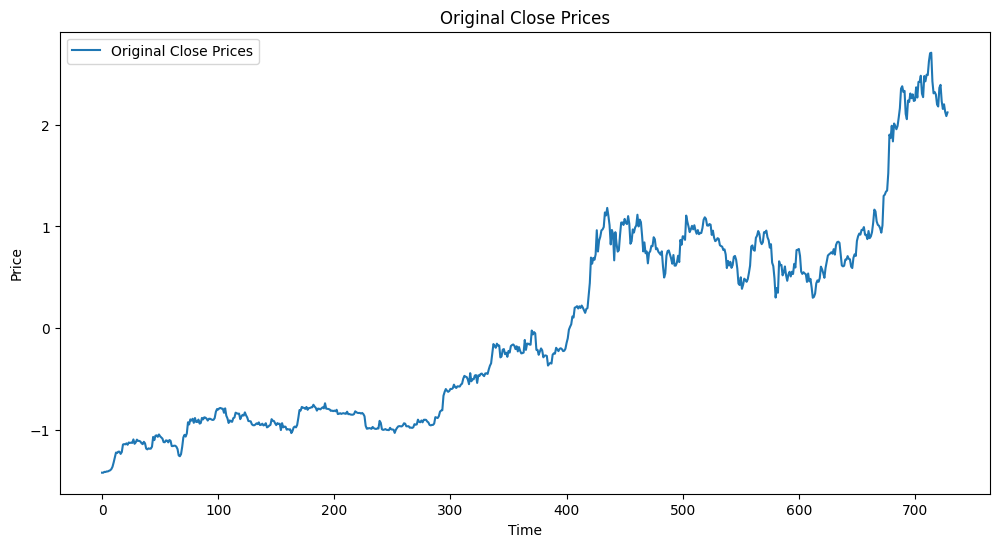

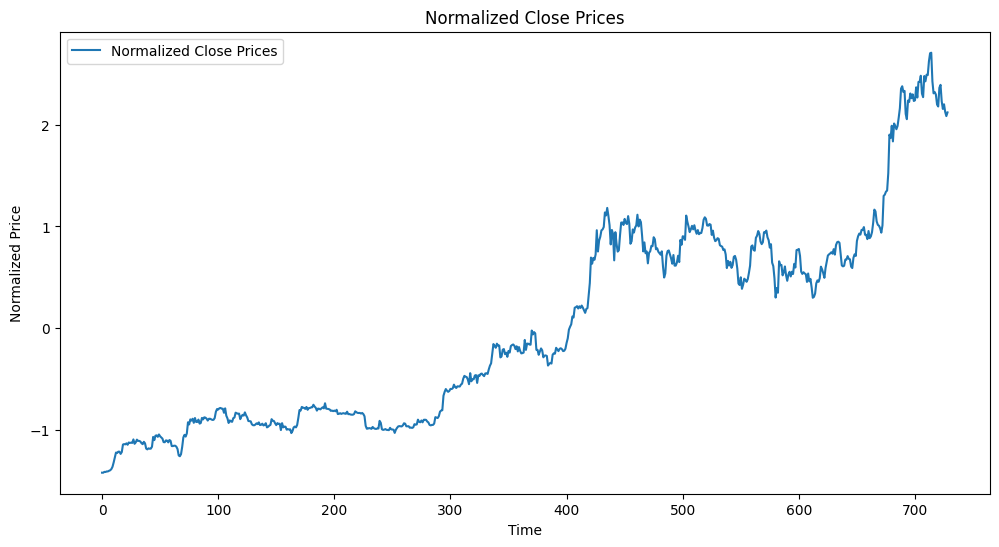

   name          open          high           low     close        volume  \
0  2781  16625.510394  16759.344023  16572.228850 -1.421798  1.209778e+10   
1  2781  16688.847264  16760.447466  16622.370328 -1.422196  1.390308e+10   
2  2781  16680.204971  16964.585185  16667.763725 -1.413730  1.842174e+10   
3  2781  16863.472057  16884.022116  16790.283041 -1.414953  1.369276e+10   
4  2781  16836.473439  16991.994121  16716.422271 -1.409633  1.441366e+10   

      marketCap                 timestamp     SMA_7   SMA_30  Volatility  
0  3.212625e+11  2023-01-02T23:59:59.999Z -1.409879 -1.24945   -1.086955  
1  3.211120e+11  2023-01-03T23:59:59.999Z -1.409879 -1.24945   -1.086955  
2  3.246582e+11  2023-01-04T23:59:59.999Z -1.409879 -1.24945   -1.086955  
3  3.241639e+11  2023-01-05T23:59:59.999Z -1.409879 -1.24945   -1.086955  
4  3.264013e+11  2023-01-06T23:59:59.999Z -1.409879 -1.24945   -1.086955  


ValueError: could not convert string to float: '2023-01-02T23:59:59.999Z'

<Figure size 1000x600 with 0 Axes>

In [131]:
# Plot original 'Close' prices
plt.figure(figsize=(12, 6))
plt.plot(data['close'], label='Original Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Original Close Prices')
plt.legend()
plt.show()

# Plot normalized 'Close' prices
plt.figure(figsize=(12, 6))
plt.plot(data['close'], label='Normalized Close Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.title('Normalized Close Prices')
plt.legend()
plt.show()

print(data.head())
# #remove the timeOpen column and timestamp column
# data = data.drop(['timeOpen'], axis=1)
# data = data.drop(['timeClose'], axis=1)
# data = data.drop(['timeHigh'], axis=1)
# data = data.drop(['timeLow'], axis=1)


plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

## pytorch data set

## 3. Define the LSTM Model
Construct an LSTM model using PyTorch.

In [107]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1, bias=False)
    
    def forward(self, lstm_output):
        weights = torch.softmax(self.attn(lstm_output), dim=1)
        return torch.sum(weights * lstm_output, dim=1)

class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out = self.attention(lstm_out)
        return self.fc(attn_out)

model = LSTMWithAttention(input_size=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

## Hyperparameter Tuning with Optuna
Optimize learning rate, batch size, and model depth.

## 4. Train the Model
Train the LSTM model using the dataset.

In [108]:
# def train_model(model, train_loader, criterion, optimizer, epochs=10):
#     for epoch in range(epochs):
#         for X_batch, y_batch in train_loader:
#             optimizer.zero_grad()
#             y_pred = model(X_batch)
#             loss = criterion(y_pred, y_batch.unsqueeze(1))
#             loss.backward()
#             optimizer.step()
#         print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# train_model(model, train_loader, criterion, optimizer, epochs=100)

def train_and_evaluate(model, optimizer, criterion=criterion, train_loader=train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return loss.item()

def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 64, 256)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    
    model = LSTMWithAttention(input_size=4, hidden_size=hidden_size, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss = train_and_evaluate(model, optimizer)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Best Hyperparameters:", study.best_params)
print("Best Loss:", study.best_value)

[I 2025-02-28 18:17:17,374] A new study created in memory with name: no-name-6480ea47-0301-4f81-aa24-b9f1987e34dd
C:\Users\Emman\AppData\Local\Temp\ipykernel_22612\388246550.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-2)


Epoch 1, Loss: 1.0700
Epoch 2, Loss: 0.7975
Epoch 3, Loss: 0.5221
Epoch 4, Loss: 0.5948
Epoch 5, Loss: 0.1218
Epoch 6, Loss: 0.1271
Epoch 7, Loss: 0.1025
Epoch 8, Loss: 0.1065
Epoch 9, Loss: 0.1214


[I 2025-02-28 18:18:17,902] Trial 0 finished with value: 0.08210235089063644 and parameters: {'hidden_size': 215, 'num_layers': 4, 'lr': 4.3487640971376235e-05}. Best is trial 0 with value: 0.08210235089063644.


Epoch 10, Loss: 0.0821
Epoch 1, Loss: 0.5879
Epoch 2, Loss: 0.1876
Epoch 3, Loss: 0.1314
Epoch 4, Loss: 0.0952
Epoch 5, Loss: 0.0464
Epoch 6, Loss: 0.0282
Epoch 7, Loss: 0.0553
Epoch 8, Loss: 0.0321
Epoch 9, Loss: 0.0347


[I 2025-02-28 18:19:08,428] Trial 1 finished with value: 0.02827749215066433 and parameters: {'hidden_size': 211, 'num_layers': 4, 'lr': 0.0012630635980178378}. Best is trial 1 with value: 0.02827749215066433.


Epoch 10, Loss: 0.0283
Epoch 1, Loss: 0.1549
Epoch 2, Loss: 0.2376
Epoch 3, Loss: 0.0657
Epoch 4, Loss: 0.0361
Epoch 5, Loss: 0.0346
Epoch 6, Loss: 0.0440
Epoch 7, Loss: 0.0151
Epoch 8, Loss: 0.0157
Epoch 9, Loss: 0.0164


[I 2025-02-28 18:19:24,268] Trial 2 finished with value: 0.016712497919797897 and parameters: {'hidden_size': 71, 'num_layers': 3, 'lr': 0.004987916765974347}. Best is trial 2 with value: 0.016712497919797897.


Epoch 10, Loss: 0.0167
Epoch 1, Loss: 0.1360
Epoch 2, Loss: 0.0818
Epoch 3, Loss: 0.1006
Epoch 4, Loss: 0.0948
Epoch 5, Loss: 0.0441
Epoch 6, Loss: 0.0621
Epoch 7, Loss: 0.0346
Epoch 8, Loss: 0.0495
Epoch 9, Loss: 0.0551


[I 2025-02-28 18:19:48,458] Trial 3 finished with value: 0.03537634760141373 and parameters: {'hidden_size': 182, 'num_layers': 2, 'lr': 0.0004383316222861486}. Best is trial 2 with value: 0.016712497919797897.


Epoch 10, Loss: 0.0354
Epoch 1, Loss: 0.2020
Epoch 2, Loss: 0.1008
Epoch 3, Loss: 0.0596
Epoch 4, Loss: 0.0606
Epoch 5, Loss: 0.0718
Epoch 6, Loss: 0.0367
Epoch 7, Loss: 0.0302
Epoch 8, Loss: 0.0174
Epoch 9, Loss: 0.0126


[I 2025-02-28 18:20:51,556] Trial 4 finished with value: 0.012858619913458824 and parameters: {'hidden_size': 215, 'num_layers': 4, 'lr': 0.0019240566557512063}. Best is trial 4 with value: 0.012858619913458824.


Epoch 10, Loss: 0.0129
Epoch 1, Loss: 0.1218
Epoch 2, Loss: 0.0784
Epoch 3, Loss: 0.0442
Epoch 4, Loss: 0.0554
Epoch 5, Loss: 0.0371
Epoch 6, Loss: 0.0234
Epoch 7, Loss: 0.0472
Epoch 8, Loss: 0.0305
Epoch 9, Loss: 0.0207


[I 2025-02-28 18:21:12,796] Trial 5 finished with value: 0.010629951022565365 and parameters: {'hidden_size': 135, 'num_layers': 3, 'lr': 0.0021748358901116905}. Best is trial 5 with value: 0.010629951022565365.


Epoch 10, Loss: 0.0106
Epoch 1, Loss: 0.1134
Epoch 2, Loss: 0.1693
Epoch 3, Loss: 0.0557
Epoch 4, Loss: 0.0674
Epoch 5, Loss: 0.0368
Epoch 6, Loss: 0.0271
Epoch 7, Loss: 0.0121
Epoch 8, Loss: 0.0219
Epoch 9, Loss: 0.0129


[I 2025-02-28 18:21:26,584] Trial 6 finished with value: 0.007490008138120174 and parameters: {'hidden_size': 68, 'num_layers': 3, 'lr': 0.00705803893361271}. Best is trial 6 with value: 0.007490008138120174.


Epoch 10, Loss: 0.0075
Epoch 1, Loss: 0.0882
Epoch 2, Loss: 0.1060
Epoch 3, Loss: 0.0705
Epoch 4, Loss: 0.0941
Epoch 5, Loss: 0.0437
Epoch 6, Loss: 0.0401
Epoch 7, Loss: 0.0412
Epoch 8, Loss: 0.0543
Epoch 9, Loss: 0.0535


[I 2025-02-28 18:21:58,099] Trial 7 finished with value: 0.01398325152695179 and parameters: {'hidden_size': 210, 'num_layers': 2, 'lr': 0.00046828074632601196}. Best is trial 6 with value: 0.007490008138120174.


Epoch 10, Loss: 0.0140
Epoch 1, Loss: 0.2167
Epoch 2, Loss: 0.1146
Epoch 3, Loss: 0.0524
Epoch 4, Loss: 0.1008
Epoch 5, Loss: 0.0706
Epoch 6, Loss: 0.0397
Epoch 7, Loss: 0.0423
Epoch 8, Loss: 0.0273
Epoch 9, Loss: 0.0263


[I 2025-02-28 18:22:11,888] Trial 8 finished with value: 0.0803612470626831 and parameters: {'hidden_size': 137, 'num_layers': 2, 'lr': 0.0008010209071404849}. Best is trial 6 with value: 0.007490008138120174.


Epoch 10, Loss: 0.0804
Epoch 1, Loss: 0.3884
Epoch 2, Loss: 0.2349
Epoch 3, Loss: 0.1270
Epoch 4, Loss: 0.0800
Epoch 5, Loss: 0.0833
Epoch 6, Loss: 0.0745
Epoch 7, Loss: 0.0522
Epoch 8, Loss: 0.0645
Epoch 9, Loss: 0.0695


[I 2025-02-28 18:22:32,742] Trial 9 finished with value: 0.02842821180820465 and parameters: {'hidden_size': 97, 'num_layers': 4, 'lr': 0.0005610117178813327}. Best is trial 6 with value: 0.007490008138120174.


Epoch 10, Loss: 0.0284
Epoch 1, Loss: 0.9623
Epoch 2, Loss: 0.9162
Epoch 3, Loss: 0.9172
Epoch 4, Loss: 0.9118
Epoch 5, Loss: 0.7439
Epoch 6, Loss: 0.4782
Epoch 7, Loss: 0.3057
Epoch 8, Loss: 0.1290
Epoch 9, Loss: 0.1497


[I 2025-02-28 18:22:46,811] Trial 10 finished with value: 0.11264325678348541 and parameters: {'hidden_size': 69, 'num_layers': 3, 'lr': 7.562901321806406e-05}. Best is trial 6 with value: 0.007490008138120174.


Epoch 10, Loss: 0.1126
Epoch 1, Loss: 0.2193
Epoch 2, Loss: 0.0359
Epoch 3, Loss: 0.0255
Epoch 4, Loss: 0.0205
Epoch 5, Loss: 0.0309
Epoch 6, Loss: 0.0243
Epoch 7, Loss: 0.0195
Epoch 8, Loss: 0.0217
Epoch 9, Loss: 0.0070


[I 2025-02-28 18:23:06,457] Trial 11 finished with value: 0.013104788959026337 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.009257535109574267}. Best is trial 6 with value: 0.007490008138120174.


Epoch 10, Loss: 0.0131
Epoch 1, Loss: 0.6123
Epoch 2, Loss: 0.1918
Epoch 3, Loss: 0.1237
Epoch 4, Loss: 0.0392
Epoch 5, Loss: 0.0351
Epoch 6, Loss: 0.0333
Epoch 7, Loss: 0.0355
Epoch 8, Loss: 0.0253
Epoch 9, Loss: 0.0167


[I 2025-02-28 18:24:06,630] Trial 12 finished with value: 0.013036759570240974 and parameters: {'hidden_size': 254, 'num_layers': 3, 'lr': 0.004067284594003536}. Best is trial 6 with value: 0.007490008138120174.


Epoch 10, Loss: 0.0130
Epoch 1, Loss: 0.5759
Epoch 2, Loss: 0.7649
Epoch 3, Loss: 0.7002
Epoch 4, Loss: 0.2286
Epoch 5, Loss: 0.1064
Epoch 6, Loss: 0.0903
Epoch 7, Loss: 0.1105
Epoch 8, Loss: 0.0834
Epoch 9, Loss: 0.0629


[I 2025-02-28 18:24:24,655] Trial 13 finished with value: 0.08268838375806808 and parameters: {'hidden_size': 110, 'num_layers': 3, 'lr': 0.00011308980973401545}. Best is trial 6 with value: 0.007490008138120174.


Epoch 10, Loss: 0.0827
Epoch 1, Loss: 1.0342
Epoch 2, Loss: 0.7921
Epoch 3, Loss: 1.0433
Epoch 4, Loss: 0.9622
Epoch 5, Loss: 0.8231
Epoch 6, Loss: 0.9550
Epoch 7, Loss: 0.8205
Epoch 8, Loss: 0.7571
Epoch 9, Loss: 0.6063


[I 2025-02-28 18:24:59,053] Trial 14 finished with value: 0.8195657730102539 and parameters: {'hidden_size': 157, 'num_layers': 3, 'lr': 1.4475723538769364e-05}. Best is trial 6 with value: 0.007490008138120174.


Epoch 10, Loss: 0.8196
Epoch 1, Loss: 0.2535
Epoch 2, Loss: 0.1165
Epoch 3, Loss: 0.0672
Epoch 4, Loss: 0.0690
Epoch 5, Loss: 0.0375
Epoch 6, Loss: 0.0241
Epoch 7, Loss: 0.0312
Epoch 8, Loss: 0.0376
Epoch 9, Loss: 0.0260


[I 2025-02-28 18:25:10,514] Trial 15 finished with value: 0.019758442416787148 and parameters: {'hidden_size': 95, 'num_layers': 2, 'lr': 0.0034623575428325082}. Best is trial 6 with value: 0.007490008138120174.


Epoch 10, Loss: 0.0198
Epoch 1, Loss: 0.1344
Epoch 2, Loss: 0.1225
Epoch 3, Loss: 0.0554
Epoch 4, Loss: 0.0323
Epoch 5, Loss: 0.0377
Epoch 6, Loss: 0.0221
Epoch 7, Loss: 0.0208
Epoch 8, Loss: 0.0135
Epoch 9, Loss: 0.0138


[I 2025-02-28 18:25:49,734] Trial 16 finished with value: 0.0069007836282253265 and parameters: {'hidden_size': 174, 'num_layers': 3, 'lr': 0.007367978319210519}. Best is trial 16 with value: 0.0069007836282253265.


Epoch 10, Loss: 0.0069
Epoch 1, Loss: 0.1308
Epoch 2, Loss: 0.0430
Epoch 3, Loss: 0.0556
Epoch 4, Loss: 0.1337
Epoch 5, Loss: 0.0507
Epoch 6, Loss: 0.0289
Epoch 7, Loss: 0.0069
Epoch 8, Loss: 0.0108
Epoch 9, Loss: 0.0061


[I 2025-02-28 18:27:23,957] Trial 17 finished with value: 0.013957204297184944 and parameters: {'hidden_size': 176, 'num_layers': 4, 'lr': 0.009892856919747242}. Best is trial 16 with value: 0.0069007836282253265.


Epoch 10, Loss: 0.0140
Epoch 1, Loss: 0.9930
Epoch 2, Loss: 0.1396
Epoch 3, Loss: 0.1204
Epoch 4, Loss: 0.1154
Epoch 5, Loss: 0.0962
Epoch 6, Loss: 0.0948
Epoch 7, Loss: 0.0733
Epoch 8, Loss: 0.0519
Epoch 9, Loss: 0.0610


[I 2025-02-28 18:27:50,918] Trial 18 finished with value: 0.026316165924072266 and parameters: {'hidden_size': 161, 'num_layers': 2, 'lr': 0.00019998789777679404}. Best is trial 16 with value: 0.0069007836282253265.


Epoch 10, Loss: 0.0263
Epoch 1, Loss: 0.3367
Epoch 2, Loss: 0.1174
Epoch 3, Loss: 0.0360
Epoch 4, Loss: 0.0558
Epoch 5, Loss: 0.0276
Epoch 6, Loss: 0.0261
Epoch 7, Loss: 0.0237
Epoch 8, Loss: 0.0138
Epoch 9, Loss: 0.0140


[I 2025-02-28 18:29:04,568] Trial 19 finished with value: 0.005881698336452246 and parameters: {'hidden_size': 242, 'num_layers': 3, 'lr': 0.0056465785040944235}. Best is trial 19 with value: 0.005881698336452246.


Epoch 10, Loss: 0.0059
Best Hyperparameters: {'hidden_size': 242, 'num_layers': 3, 'lr': 0.0056465785040944235}
Best Loss: 0.005881698336452246


## 5. Evaluate and Visualize Results
Visualize predictions and compare with actual values.

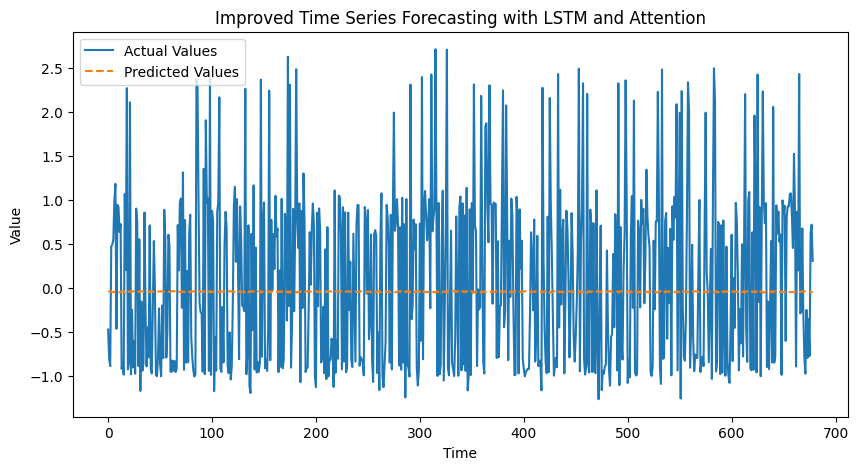

Mean Squared Error: 0.9842
R-squared Score: -0.0265
Mean Absolute Percentage Error: 99.6863


In [109]:
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        predictions.extend(y_pred.numpy().flatten())
        actuals.extend(y_batch.numpy().flatten())

# Plot results
plt.figure(figsize=(10,5))
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, label='Predicted Values', linestyle='dashed')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Improved Time Series Forecasting with LSTM and Attention')
plt.show()

#print the accuracy of the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error: {mse:.4f}')

# Calculate and print the R-squared score
r2 = r2_score(actuals, predictions)
print(f'R-squared Score: {r2:.4f}')

#calculate the anothe accuracy metric
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(actuals, predictions)

print(f'Mean Absolute Percentage Error: {mape:.4f}')

## Discussion

## Conclusion